In [1]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import LassoCV, RidgeCV
from utils import *
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import root_mean_squared_error

In [2]:
df_train = pd.read_parquet("data/nyc-taxis-tips/train_preprocessed.parquet")
X = df_train.drop("tip_amount", axis=1)
Y = df_train['tip_amount']
display(X.columns)

Index(['passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tolls_amount', 'improvement_surcharge', 'congestion_surcharge',
       'Airport_fee', 'PU_location_lat', 'PU_location_lon', 'DO_location_lat',
       'DO_location_lon', 'is_rush_hour', 'duration', 'PU_loc', 'DO_loc',
       'VendorID_1', 'VendorID_2', 'RatecodeID_1.0', 'RatecodeID_2.0',
       'RatecodeID_3.0', 'RatecodeID_4.0', 'RatecodeID_5.0', 'RatecodeID_99.0',
       'store_and_fwd_flag_N', 'store_and_fwd_flag_Y', 'payment_type_1',
       'payment_type_2', 'payment_type_3', 'payment_type_4', 'PU_borough_7',
       'PU_borough_1', 'PU_borough_3', 'PU_borough_4', 'PU_borough_2',
       'PU_borough_6', 'PU_borough_5', 'DO_borough_7', 'DO_borough_1',
       'DO_borough_3', 'DO_borough_4', 'DO_borough_2', 'DO_borough_6',
       'DO_borough_5'],
      dtype='object')

# Ridge regression

All this code is from TP_reg-1 (copy paste for clarity in a separate notebook without exploratory data analysis)

In [3]:
# divise les données 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
print(X_train.columns)
print(X_train.shape, X_test.shape)

Index(['passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tolls_amount', 'improvement_surcharge', 'congestion_surcharge',
       'Airport_fee', 'PU_location_lat', 'PU_location_lon', 'DO_location_lat',
       'DO_location_lon', 'is_rush_hour', 'duration', 'PU_loc', 'DO_loc',
       'VendorID_1', 'VendorID_2', 'RatecodeID_1.0', 'RatecodeID_2.0',
       'RatecodeID_3.0', 'RatecodeID_4.0', 'RatecodeID_5.0', 'RatecodeID_99.0',
       'store_and_fwd_flag_N', 'store_and_fwd_flag_Y', 'payment_type_1',
       'payment_type_2', 'payment_type_3', 'payment_type_4', 'PU_borough_7',
       'PU_borough_1', 'PU_borough_3', 'PU_borough_4', 'PU_borough_2',
       'PU_borough_6', 'PU_borough_5', 'DO_borough_7', 'DO_borough_1',
       'DO_borough_3', 'DO_borough_4', 'DO_borough_2', 'DO_borough_6',
       'DO_borough_5'],
      dtype='object')
(75000, 45) (25000, 45)


In [4]:
# normaliser les données 

# Séparation des colonnes encodées (one-hot encoded) et des colonnes numériques à normaliser
columns_to_norm = [
    'passenger_count',
    'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tolls_amount',
    'improvement_surcharge', 'congestion_surcharge', 'Airport_fee','duration'
]

cols_to_exclude = [
    'PU_location_lat', 'PU_location_lon', 'DO_location_lat',
    'DO_location_lon', 'PU_loc', 'DO_loc'
]

# Copie des colonnes à exclure pour les conserver
X_train_excluded = X_train[cols_to_exclude]
X_test_excluded = X_test[cols_to_exclude]


X_train = X_train.drop(cols_to_exclude, axis=1)
X_test = X_test.drop(cols_to_exclude, axis=1)

# Normaliser les colonnes numériques de l'ensemble d'entraînement
scaler = StandardScaler()
X_train_normed = X_train.copy()
X_test_normed = X_test.copy()

# Normalisation sur l'ensemble d'entraînement
X_train_normed[columns_to_norm] = scaler.fit_transform(X_train[columns_to_norm])

# Appliquer la même transformation sur l'ensemble de test
X_test_normed[columns_to_norm] = scaler.transform(X_test[columns_to_norm])


# Réintégrer les colonnes exclues dans les ensembles normalisés
X_train_normed = pd.concat([X_train_normed, X_train_excluded], axis=1)
X_test_normed = pd.concat([X_test_normed, X_test_excluded], axis=1)

In [5]:
X_train_normed.shape

(75000, 45)

In [6]:
# Modèle Ridge : 
model_ridge_CV = RidgeCV(alphas=np.linspace(15, 25, 100))
model_ridge_CV.fit(X_train_normed, y_train)
y_pred = model_ridge_CV.predict(X_test_normed)

mse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Affichage des résultats
print("Mean Squared Error (MSE):", mse)
print("Coefficient de détermination (R2 Score):", r2)
print("meilleur alpha : ", model_ridge_CV.alpha_)

Mean Squared Error (MSE): 2.3024178506814574
Coefficient de détermination (R2 Score): 0.6112175433047391
meilleur alpha :  15.0


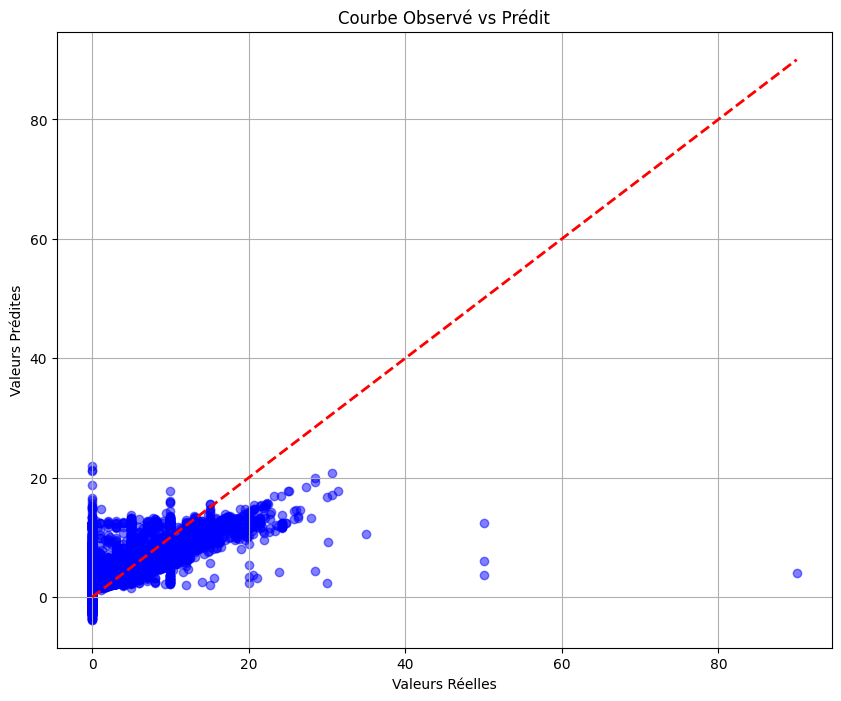

In [7]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 8))
plt.scatter(y_pred, residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--', lw=2)
plt.xlabel("Valeurs Prédites")
plt.ylabel("Résidus")
plt.title("Courbe des Résidus")
plt.grid()
plt.show()



# Random Forest Regressor

In [8]:
#  modèle Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [300, 400],
    'max_depth': [5,10 ],
    'min_samples_split': [3, 5],
    'min_samples_leaf': [5, 10],
}

# Modèle RandomForest
rf_model = RandomForestRegressor(random_state=42)

# RandomizedSearchCV pour optimiser les hyperparamètres
rf_grid = GridSearchCV(estimator=rf_model, 
                       param_grid=param_grid, 
                       cv=5,  
                       verbose=2, 
                       n_jobs=-1)  # Utiliser tous les cœurs disponibles

# Entraîner le modèle avecGridSearchCV sur les données normalisées
rf_grid.fit(X_train_normed, y_train)

# Meilleurs hyperparamètres trouvés
best_params = rf_grid.best_params_

# Prédictions avec le modèle optimisé
y_pred = rf_grid.best_estimator_.predict(X_test_normed)

# Calcul du Mean Squared Error (MSE) et du R2 Score
mse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Affichage des résultats
print("Meilleurs hyperparamètres trouvés:", best_params)
print("Mean Squared Error (MSE):", mse)
print("Coefficient de détermination (R2 Score):", r2)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=300; total time=  24.8s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=  24.8s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=300; total time=  25.4s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=300; total time=  25.5s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=300; total time=  25.5s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=300; total time=  25.5s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=  25.5s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=  25.5s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=  25.6s
[CV] END max_depth=5, min_samples_leaf=

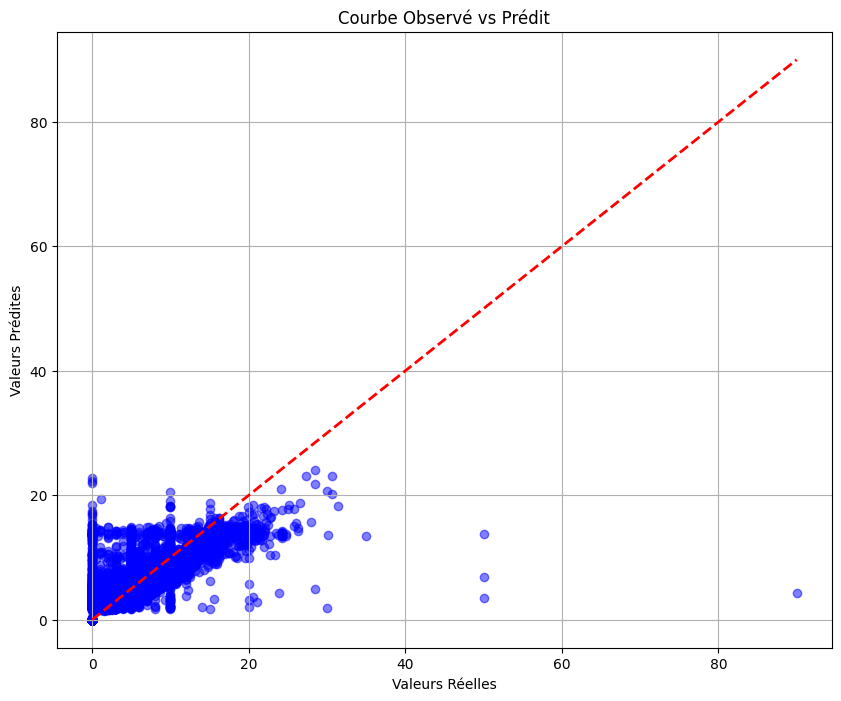

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', lw=2)
plt.xlabel("Valeurs Réelles")
plt.ylabel("Valeurs Prédites")
plt.title("Courbe Observé vs Prédit")
plt.grid()
plt.show()

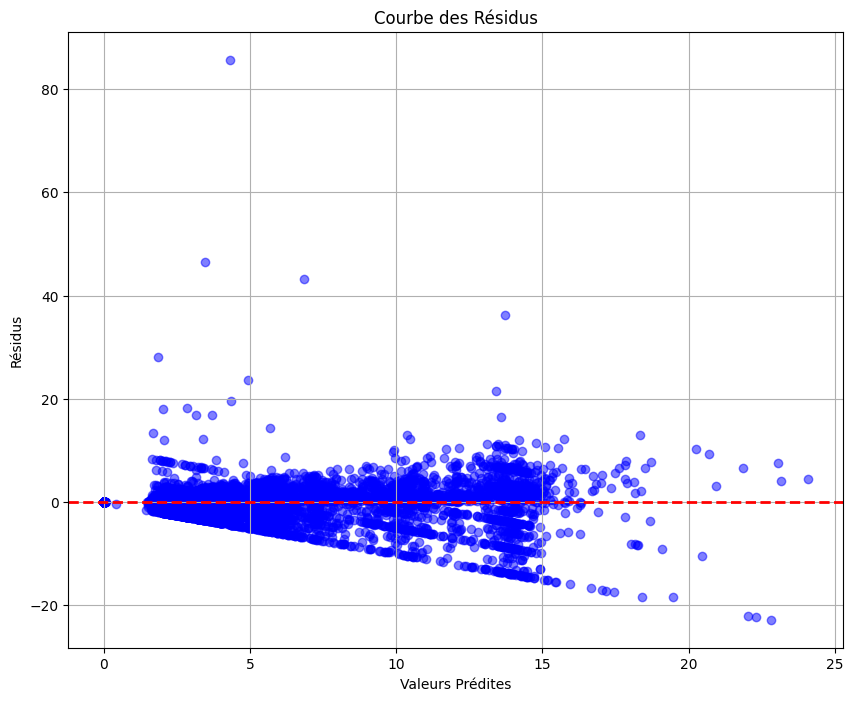

In [11]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 8))
plt.scatter(y_pred, residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--', lw=2)
plt.xlabel("Valeurs Prédites")
plt.ylabel("Résidus")
plt.title("Courbe des Résidus")
plt.grid()
plt.show()


In [9]:
# test data for Kaggle submission
test = pd.read_parquet("data/nyc-taxis-tips/test_preprocessed.parquet")

test.drop(columns=["RatecodeID_6.0"], inplace=True)
columns_to_norm = [
    'passenger_count',
    'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tolls_amount',
    'improvement_surcharge', 'congestion_surcharge', 'Airport_fee', 'duration'
]
cols_to_exclude = [
    'PU_location_lat', 'PU_location_lon', 'DO_location_lat',
    'DO_location_lon', 'PU_loc', 'DO_loc'
]

X_sub_excluded = test[cols_to_exclude]
X_sub = test.drop(cols_to_exclude, axis=1)

X_sub[columns_to_norm] = scaler.transform(X_sub[columns_to_norm])

X_sub = pd.concat([X_sub, X_sub_excluded], axis=1)


#predictions = model_ridge_CV.predict(X_sub)
predictions = rf_grid.predict(X_sub)

In [10]:
df_pred = pd.DataFrame(predictions, columns=["tip_amount"]).reset_index().rename(columns={"index": "row_ID"})
display(df_pred.head(15))
print(sum(df_pred["tip_amount"]<0))
df_pred.loc[df_pred.tip_amount < 0, "tip_amount"] = 0
#df_pred.to_parquet("submission/nyc-taxis-tips/regression_sub_1bis.parquet", index=False)
df_pred.to_parquet("submission/nyc-taxis-tips/RF_sub_1bis.parquet", index=False)

,row_ID,tip_amount
0,0,1.657879
1,1,2.564245
2,2,0.000000
3,3,1.896428
4,4,0.000000
5,5,7.071094
6,6,4.343084
7,7,0.000000
8,8,4.258585
9,9,9.429999


0


In [11]:
df_pred.head(25)

,row_ID,tip_amount
0,0,1.657879
1,1,2.564245
2,2,0.000000
3,3,1.896428
4,4,0.000000
5,5,7.071094
6,6,4.343084
7,7,0.000000
8,8,4.258585
9,9,9.429999


<Axes: xlabel='tip_amount', ylabel='Count'>

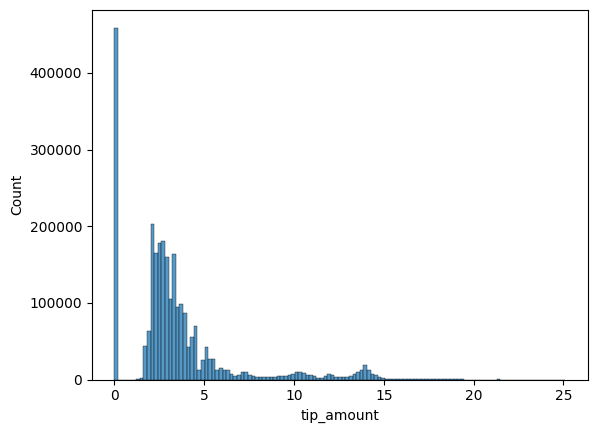

In [12]:
sns.histplot(df_pred, x="tip_amount", bins=125)